# Uncovering Latent Market Structure in BTC <br> with Principal Component Analysis (PCA)

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.decomposition import PCA
from scipy.spatial.distance import mahalanobis
from sklearn.preprocessing import StandardScaler

In [3]:
# Download OHLCV minutely BTC 2023 data
df = pd.read_csv('./df_btc.csv', index_col=0).dropna()
df.index = pd.to_datetime(df.index)
df = df.loc[:'2023-05-31 23:59:00',:]
df.head()

,OPEN,CLOSE,HIGH,LOW,VOLUME
date,,,,,
2023-01-01 00:00:00,16537.5,16538.0,16538.0,16534.3,2.820697e+06
2023-01-01 00:01:00,16538.0,16534.9,16538.0,16534.9,7.323633e+05
2023-01-01 00:02:00,16534.9,16531.4,16535.0,16531.3,1.657072e+06
2023-01-01 00:03:00,16531.4,16526.9,16531.4,16526.6,5.254048e+06
2023-01-01 00:04:00,16527.0,16529.2,16529.3,16523.0,3.491635e+06


# Features Builder Class

In [4]:
class FeatureBuilder:

    def __init__(self, df, config):
        """Fetch dataframe and config, extract columns"""

        self.features = df.copy()
        self.config = config.copy()

        self.OPEN = self.features['OPEN']
        self.CLOSE = self.features['CLOSE']
        self.HIGH = self.features['HIGH']
        self.LOW = self.features['LOW']
        self.VOLUME = self.features['VOLUME']
        self.LOG_RETURN = np.log(self.OPEN / self.OPEN.shift())

    def distribution_features(self):
        """Standard Deviation, Skewness, and Kurtosis"""

        for w in self.config['DISTRIBUTION']:
            self.features[f'STD_{w}'] = self.LOG_RETURN.rolling(w).std()
            self.features[f'SKEW_{w}'] = self.LOG_RETURN.rolling(w).skew()
            self.features[f'KURT_{w}'] = self.LOG_RETURN.rolling(w).kurt()

    def momentum_features(self):
        """Directional & Oscillator Features"""

        # LOG RETURN
        self.features['LOG_RETURN'] = self.LOG_RETURN

        # RATE OF CHANGE
        for w in self.config['MOMENTUM']['ROC']:
            self.features[f'ROC_{w}'] = ((self.OPEN - self.OPEN.shift(w)) / self.OPEN.shift(w)) * 100

        # MOVING AVERAGES
        for w in self.config['MOMENTUM']['MA']:
            self.features[f"SMA_{w}"] = self.OPEN.rolling(w).mean()
            self.features[f"EWMA_{w}"] = self.OPEN.ewm(w, adjust=False).mean()

        # RELATIVE STRENGH INDEX (RSI)
        delta = self.OPEN.diff()
        for w in self.config['MOMENTUM']['RSI']:
            gain = (delta.where(delta > 0, 0)).rolling(w).mean()
            loss = (-delta.where(delta < 0, 0)).rolling(w).mean()
            self.features[f"RSI_{w}"] = 100 - (100 / (1 + gain / (loss + 1e-9)))

        # MACD & MACD SPREAD
        for w in self.config['MOMENTUM']['MACD']:
            short_ewma = self.OPEN.ewm(w[0], adjust=False).mean()
            long_ewma = self.OPEN.ewm(w[1], adjust=False).mean()
            self.features[f"MACD_{w[0]}_{w[1]}"] = short_ewma - long_ewma
            macd = self.features[f"MACD_{w[0]}_{w[1]}"]
            macd_signal = macd.ewm(9, adjust=False).mean()
            self.features[f"MACD_SPREAD_{w[0]}_{w[1]}"] = macd - macd_signal

        # STOCHASTIC OSCILATOR
        for w in self.config['MOMENTUM']['STOCH']:
            low_min = self.LOW.rolling(w).min()
            high_max = self.HIGH.rolling(w).max()
            self.features[f'STOCH_{w}'] = 100 * (self.OPEN - low_min) / (high_max - low_min)

        # TRIPLE EWMA (TEWMA)
        for w in self.config['MOMENTUM']['TEWMA']:
            ema1 = self.OPEN.ewm(w, adjust=False).mean()
            ema2 = ema1.ewm(w, adjust=False).mean()
            ema3 = ema2.ewm(w, adjust=False).mean()
            self.features[f"TEWMA_{w}"] = 3 * ema1 - 3 * ema2 + ema3

    def volatility_features(self):
        """Dispersion Features"""

        # AVERAGE TRUE RANGE (ATR)
        for w in self.config['VOLATILITY']['ATR']:
            high_low = self.HIGH - self.LOW
            high_close = np.abs(self.HIGH - self.CLOSE.shift())
            low_close = np.abs(self.LOW - self.CLOSE.shift())
            true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
            self.features[f"ATR_{w}"] = true_range.rolling(w).mean()

        # PARKINSON VOLATILITY (PARK)
        for w in self.config['VOLATILITY']['PARK']:
            self.features[f"PARK_VOL_{w}"] = np.sqrt((1 / (4 * np.log(2))) *
                                                     (np.log(self.HIGH / self.LOW) ** 2)
                                                     .rolling(w).mean())

        # BOLLINGER BANDS (BB)
        for w in self.config['VOLATILITY']['BB']:
            sma = self.OPEN.rolling(w).mean()
            std = self.OPEN.rolling(w).std()
            upper, lower = sma + 2 * std, sma - 2 * std
            self.features[f"BB_WIDTH_{w}"] = upper - lower
            self.features[f"BB_POS_{w}"] = (self.OPEN - lower) / ((upper - lower) + 1e-9)

    def liquidity_features(self):
        """Volume-driven Features"""

        # VOLUME MA & RATIO
        for w in self.config['LIQUIDITY']['MA']:
            volume_sma = self.VOLUME.rolling(w).mean()
            self.features[f'VOLUME_SMA_{w}'] = volume_sma
            self.features[f'VOLUME_RATIO_{w}'] = self.VOLUME / volume_sma

        # ON-BALANCE VOLUME (OBV)
        self.features['OBV'] = (np.sign(self.features['LOG_RETURN']) * self.VOLUME).cumsum()

        # MONEY FLOW RATIO (MFR)
        avg_price = (self.HIGH + self.LOW + self.CLOSE) / 3
        money_flow = avg_price * self.VOLUME
        for w in self.config['LIQUIDITY']['MFR']:
            mf_mean = money_flow.rolling(w).mean()
            self.features[f'MF_RATIO_{w}'] = money_flow / mf_mean

    def microstructure_features(self):
        """Candle geometry and order flow imbalance"""

        candle_range = self.HIGH - self.LOW
        body_size = abs(self.CLOSE - self.OPEN)
        upper_body = self.features[['OPEN', 'CLOSE']].max(axis=1)
        lower_body = self.features[['OPEN', 'CLOSE']].min(axis=1)

        close_low = self.CLOSE - self.LOW
        high_close = self.HIGH - self.CLOSE
        close_open = self.CLOSE - self.OPEN

        # CANDLE FEATURES
        self.features['CANDLE_RANGE'] = candle_range / self.CLOSE
        self.features['BODY_SIZE'] = body_size / self.CLOSE
        self.features['UPPER_SHADOW'] = (self.HIGH - upper_body) / self.CLOSE
        self.features['LOWER_SHADOW'] = (lower_body - self.LOW) / self.CLOSE

        # BUY/SELL PRESSURE
        self.features['BUY_PRESSURE'] = np.clip((close_low) / (candle_range + 1e-9), 0, 1) * 100
        self.features['SELL_PRESSURE'] = np.clip((high_close) / (candle_range + 1e-9), 0, 1) * 100
        self.features['TREND_STRENGTH'] = (close_open) / (candle_range + 1e-9) * 100

    def temporal_features(self):
        """Cyclical time encodings to capture seasonality"""

        self.features['HOUR_SIN'] = np.sin(2 * np.pi * self.features.index.hour / 24)
        self.features['HOUR_COS'] = np.cos(2 * np.pi * self.features.index.hour / 24)
        self.features['MINUTE_SIN'] = np.sin(2 * np.pi * self.features.index.minute / 60)
        self.features['MINUTE_COS'] = np.cos(2 * np.pi * self.features.index.minute / 60)
        self.features['WEEKDAY_SIN'] = np.sin(2 * np.pi * self.features.index.dayofweek / 7)

    def handle_na(self, threshold=0.05):
        """Compute NaN ratio and drop NaN values"""

        na_ratio = self.features.isna().sum().sum() / (self.features.shape[0] * self.features.shape[1])
        print(f"Missing Value Ratio: {na_ratio:.2%}")

        if na_ratio < threshold:
            self.features.dropna(inplace=True)
            print("NaN values dropped.")
        else:
            print("Consider imputation: NaN ratio above threshold.")

    def run(self):
        """Run all methods"""

        self.distribution_features()
        self.momentum_features()
        self.volatility_features()
        self.liquidity_features()
        self.microstructure_features()
        self.temporal_features()
        self.handle_na()

        return self.features

In [5]:
# Set up config dictionary for Features Builder
config = {
    'MOMENTUM': {
        'ROC': [5, 10, 20, 60],
        'RSI': [14, 21, 28],
        'MACD': [(6, 12), (12, 24)],
        'STOCH': [10, 30, 60],
        'MA': [5, 10, 20, 50],
        'TEWMA': [20, 40]
    },

    'VOLATILITY': {
        'ATR': [14, 28, 60],
        'BB': [10, 20],
        'PARK': [30, 60]
    },

    'LIQUIDITY': {
        'MA': [10, 20, 50],
        'MFR': [5, 10, 20]
    },

    'DISTRIBUTION': [10, 50, 100, 150]
}

In [6]:
# Build features
builder = FeatureBuilder(df, config)
features_df = builder.run()

Missing Value Ratio: 0.01%
NaN values dropped.


# Features Preprocessor Class

In [7]:
class FeaturePreprocessor:

    def __init__(self, features_df, target='OPEN', shift=2):
        """Fetch dataframe, target, and shift"""

        self.features = features_df.copy()
        self.target = target
        self.shift = shift

    def split_X_y(self):
        """Split features X and target y"""

        # Shift target such that y(t) = Open(t+shift)
        y = self.features[[self.target]].shift(-self.shift)

        # Store X and y, avoiding forward-looking bias
        X = self.features.drop(self.target, axis=1)
        X, y = X.align(y, join='inner', axis=0)
        self.X = X.dropna()
        self.y = y.loc[self.X.index]

    def standardize_X(self):
        """Standardize features X to zero mean and variance"""

        scaler = StandardScaler()
        scaled_X = scaler.fit_transform(self.X)
        self.standard_X = pd.DataFrame(scaled_X, columns=self.X.columns, index=self.X.index)

    def plot_standard_X(self):
        """Plot standardized features"""

        features = self.standard_X.columns
        n_features = len(features)

        n_cols = int(np.ceil(np.sqrt(n_features))) + 3
        n_rows = int(np.ceil(n_features / n_cols))
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 8))
        axes = axes.flatten()

        # Plot histogram for each feature
        for i, col in enumerate(features):
            sns.histplot(self.standard_X[col], kde=True, stat='percent', ax=axes[i], bins=20)
            axes[i].set_title(f"{col}", fontsize=10)
            axes[i].set_xlabel("")
            axes[i].set_ylabel("")
            axes[i].axvline(0, color='red', linestyle='-', linewidth=1)

        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        fig.suptitle("Standardized Features Distributions",
                     fontsize=16, fontweight='bold', y=1)
        plt.tight_layout()
        plt.show()

    def run(self):
        """Run all methods"""

        self.split_X_y()
        self.standardize_X()
        self.plot_standard_X()

        return self.standard_X, self.y

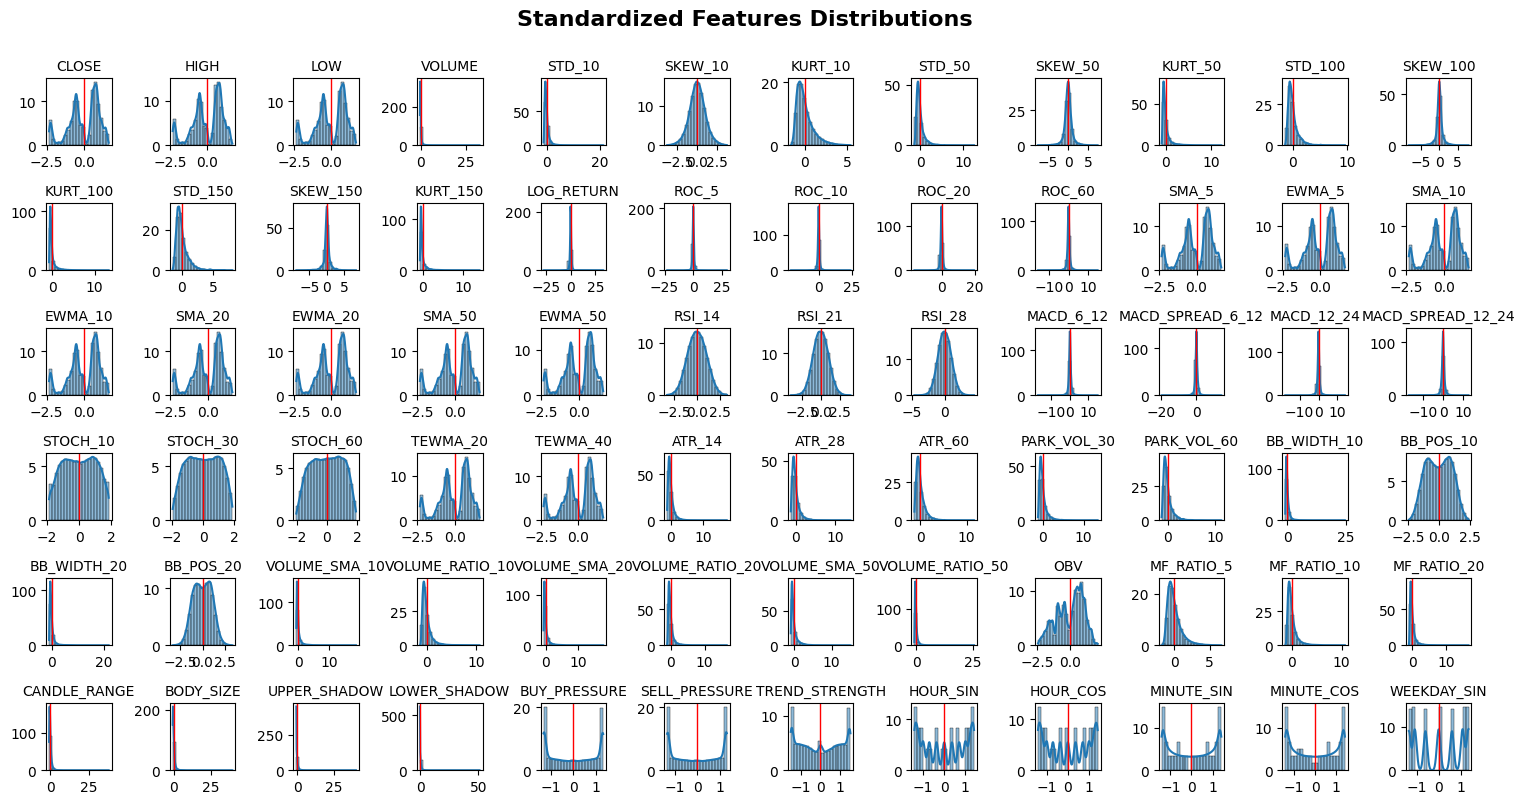

In [8]:
# Preprocess features
preprocessor = FeaturePreprocessor(features_df)
X, y = preprocessor.run()

# PCA Class

In [9]:
class PrincipalComponent:

    def __init__(self, X, n_components=None):
        """Fetch X and n_components"""

        self.X = X
        self.n_components = n_components

    def perform_pca(self):
        """Run PCA and store attributes"""

        if self.n_components is None:
            self.n_components = min(self.X.shape[0], self.X.shape[1])

        # Instantiate model, fit and transform X
        self.pca_model = PCA(n_components=self.n_components)
        components = self.pca_model.fit_transform(self.X)

        # Store eigenvalues
        self.explained_variance = self.pca_model.explained_variance_
        self.explained_variance_ratio = self.pca_model.explained_variance_ratio_
        self.cumulative_variance_ratio = np.cumsum(self.explained_variance_ratio)

        # Store loadings
        loadings = self.pca_model.components_.T * np.sqrt(self.explained_variance)
        components_cols = [f'PC{i+1}' for i in range(components.shape[1])]
        self.loadings_df = pd.DataFrame(loadings, index=self.X.columns, columns=components_cols)

        # Store top-contributing features per component
        self.top_features = {}
        for component in self.loadings_df.columns[:3]:
            top_5 = self.loadings_df[component].abs().sort_values(ascending=False).head(5)
            self.top_features[component] = top_5.index.tolist()

        # Store scores
        self.components_df = pd.DataFrame(components, columns=components_cols, index=self.X.index)

        # Send validation message
        print('PCA: Done.')

    def plot_eigenvalues(self):
        """Generate scree plot and cumulative variance explaiend plot"""

        # Scree plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
        n_show = min(50, len(self.explained_variance))

        ax1.plot(range(1, n_show+1), self.explained_variance[:n_show], 'bo-', linewidth=2, markersize=6)
        ax1.axhline(y=1, color='red', linestyle='--', label='Kaiser Criterion (λ=1)')
        ax1.set_xlabel('Principal Component')
        ax1.set_ylabel('Eigenvalue')
        ax1.set_title('Scree Plot: Eigenvalue by Principal Component', weight='bold')
        ax1.grid(True, alpha=0.3)
        ax1.legend()

        # Cumulative variance explained plot
        ax2.plot(range(1, n_show+1), self.cumulative_variance_ratio[:n_show]*100,
                 'go-', linewidth=2, markersize=6)
        ax2.axhline(y=80, color='orange', linestyle='--', label='80% Variance')
        ax2.axhline(y=90, color='red', linestyle='--', label='90% Variance')
        ax2.set_xlabel('Number of Components')
        ax2.set_ylabel('Cumulative Variance Explained (%)')
        ax2.set_title('Cumulative Variance Explained by Principal Components', weight='bold')
        ax2.grid(True, alpha=0.3)
        ax2.legend()

        plt.suptitle("Scree Plots: Eigenvalues Distribution", fontsize=12, fontweight='bold', y=0.99)
        plt.tight_layout()

    def plot_loadings_2D(self):
        """Generate loading plots for all component pairs"""

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

        # Plot each pair using helper method _plot_loading_pair
        self.colors_dic = {'PC1': 'steelblue', 'PC2': 'darkorange', 'PC3': 'seagreen'}
        self._plot_loading_pair(ax1, 'PC1', 'PC2')
        self._plot_loading_pair(ax2, 'PC1', 'PC3')
        self._plot_loading_pair(ax3, 'PC2', 'PC3')

        # Formatting
        handles, labels = ax1.get_legend_handles_labels()
        ax1.legend(handles, labels, loc='upper left', fontsize=10, frameon=True)
        ax2.legend(handles, labels, loc='upper right', fontsize=10, frameon=True)
        ax3.legend(handles, labels, loc='upper right', fontsize=10, frameon=True)
        plt.suptitle("Loading Plots (2D)", fontsize=14, fontweight='bold', y=0.98)
        plt.tight_layout()

    def _plot_loading_pair(self, ax, component_x, component_y):
        """Helper: Generate loading plot for component_x and component_y"""

        # Plot top-contributing features
        for component, color in self.colors_dic.items():

            # Scatter points
            top_features = self.top_features.get(component, [])
            top_loadings = self.loadings_df.loc[top_features, [component_x, component_y]].values
            ax.scatter(top_loadings[:, 0], top_loadings[:, 1], color=color,
                       s=60, label=f'Top 5 {component}', edgecolor='black')

            # Generate cluster circles
            x_center, y_center = top_loadings.mean(axis=0)
            radius = np.max(np.linalg.norm(top_loadings - [x_center, y_center], axis=1)) + 0.03
            circle = plt.Circle((x_center, y_center), radius, color=color, fill=False,
                                linewidth=1.8, linestyle='--', alpha=0.8)
            ax.add_patch(circle)

        # Plot remaining features
        ax.scatter(self.loadings_df[component_x], self.loadings_df[component_y],
                   color='grey', s=30, alpha=0.4, label='Remaining Features',
                   edgecolor='black')

        ax.axhline(y=0, color='black', linewidth=1)
        ax.axvline(x=0, color='black', linewidth=1)
        ax.set_xlabel(f'{component_x} Loadings', fontsize=10)
        ax.set_ylabel(f'{component_y} Loadings', fontsize=10)
        ax.set_title(f'{component_x} vs {component_y}', fontsize=11, fontweight='bold')
        ax.grid(alpha=0.3)

    def plot_loadings_summary(self):
        """Generate 3D loading plot and cross-component analysis"""

        fig = plt.figure(figsize=(15, 4))
        gs = gridspec.GridSpec(1, 2, width_ratios=[1.2, 1], wspace=0.25)

        # Generate 2D cross-component loadings using helper _plot_cross_component
        ax2d = fig.add_subplot(gs[0, 0])
        self._plot_cross_component(ax2d)

        # Generate 3D loadings plot using helper _plot_loadings_3D
        ax3d = fig.add_subplot(gs[0, 1], projection='3d')
        ax3d.view_init(25, 35)
        self._plot_loadings_3D(ax3d)

    def _plot_loadings_3D(self, ax):
        """Helper: Generate 3D loading plot"""

        components = ['PC1', 'PC2', 'PC3']
        loadings = self.loadings_df[components]
        norms = np.linalg.norm(loadings.values, axis=1)

        # Scatter all points
        ax.scatter(loadings['PC1'], loadings['PC2'], loadings['PC3'], c=norms,
                   cmap='viridis', s=40, alpha=0.8, edgecolor='k', linewidth=0.8)

        # Plot formatting
        ax.set_xlabel('PC1 Loadings', labelpad=8, fontsize=9)
        ax.set_ylabel('PC2 Loadings', labelpad=8, fontsize=9)
        ax.set_zlabel('PC3 Loadings', labelpad=6, fontsize=9)
        ax.zaxis.set_rotate_label(False)
        ax.zaxis.label.set_rotation(92)
        ax.set_title('PCA Loadings in 3D Eigenspace',
                     fontsize=10, fontweight='bold', y=0.98)

        # Generate color bar for Euclidian distance
        sm = plt.cm.ScalarMappable(cmap='viridis')
        sm.set_array(norms)
        plt.colorbar(sm, ax=ax, shrink=0.5, alpha= 0.7, aspect=20,
                     pad=0.03, label='Euclidian Distance')

    def _plot_cross_component(self, ax):
        """Helper: Generate cross-component loading analysis for top 5 features per PC."""

        components = list(self.top_features.keys())[:3]
        colors = self.colors_dic
        feature_groups = [self.top_features[c] for c in components]
        x_labels = sum(feature_groups, [])
        x_positions = np.arange(len(x_labels))

        # Plot loadings for each component
        for comp in components:
            y = self.loadings_df.loc[x_labels, comp]
            ax.plot(x_positions, y, 'o-', color=colors[comp],
                    label=comp, linewidth=2, markersize=5)

        # Shade regions for each feature group
        seg_w = len(feature_groups[0])
        for i, comp in enumerate(components):
            start, end = i * seg_w, (i + 1) * seg_w
            ax.axvspan(start - 0.5, end - 0.5, color=colors[comp], alpha=0.08)
            ax.text((start + end - 1) / 2, ax.get_ylim()[1] * 0.9, comp,
                    ha='center', va='top', color=colors[comp],
                    fontweight='bold', alpha=0.8)

        # Formatting
        ax.set_xticks(x_positions)
        ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=9)
        ax.axhline(0, color='k', linewidth=1)
        ax.set_title("Cross-Component Loadings on Top 5 Features per PC", fontsize=12, fontweight='bold')
        ax.set_ylabel("Feature Loadings", fontsize=10)
        ax.set_xlabel("Top Features by Principal Component", fontsize=10)
        ax.legend(title="Principal Components", frameon=True, fontsize=9)
        ax.grid(alpha=0.3)

    def plot_scores(self):
        """Generate score plots for all component pairs"""

        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        pairs = [('PC1', 'PC2'), ('PC1', 'PC3'), ('PC2', 'PC3')]

        for ax, (x_pc, y_pc) in zip(axes, pairs):
            data_pair = self.components_df[[x_pc, y_pc]].values
            mean = data_pair.mean(axis=0)
            cov = np.cov(data_pair, rowvar=False)
            cov_inv = np.linalg.inv(cov)

            # Compute Mahalanobis distance
            mahal_distances = np.array([mahalanobis(point, mean, cov_inv) for point in data_pair])

            # Scatter points colored by Mahalanobis distance
            scatter = ax.scatter(
                self.components_df[x_pc], self.components_df[y_pc],
                c=mahal_distances, cmap='viridis', s=20, alpha=0.8)

            # Formatting
            ax.set_xlabel(f"{x_pc} Score", fontsize=11)
            ax.set_ylabel(f"{y_pc} Score", fontsize=11)
            ax.set_title(f"{x_pc} vs {y_pc}", fontsize=12, fontweight='normal')
            ax.grid(alpha=0.3)

            # Generate color bar
            cbar = fig.colorbar(scatter, ax=ax, pad=0.02)
            cbar.set_label('Mahalanobis Distance', fontsize=11)
            cbar.solids.set_alpha(0.8)

        fig.suptitle('Score Plots', fontsize=14, fontweight='bold')
        plt.tight_layout()

In [10]:
# Instantiate model
pca_model = PrincipalComponent(X)
pca_model.perform_pca()

PCA: Done.


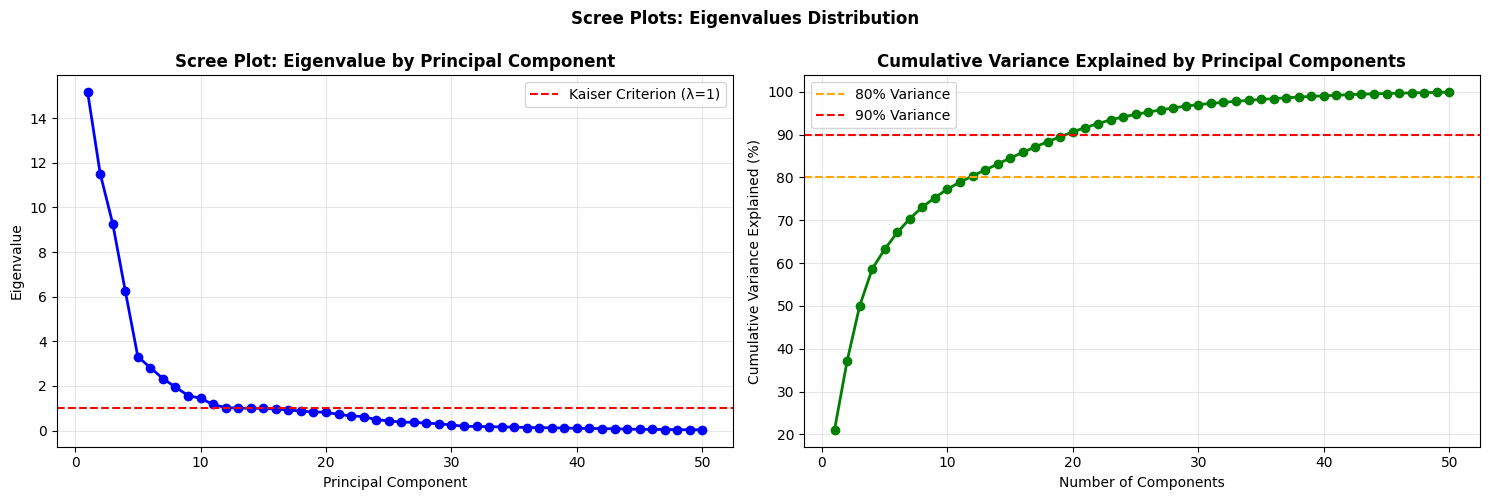

In [11]:
# Plot eigenvalues
pca_model.plot_eigenvalues()

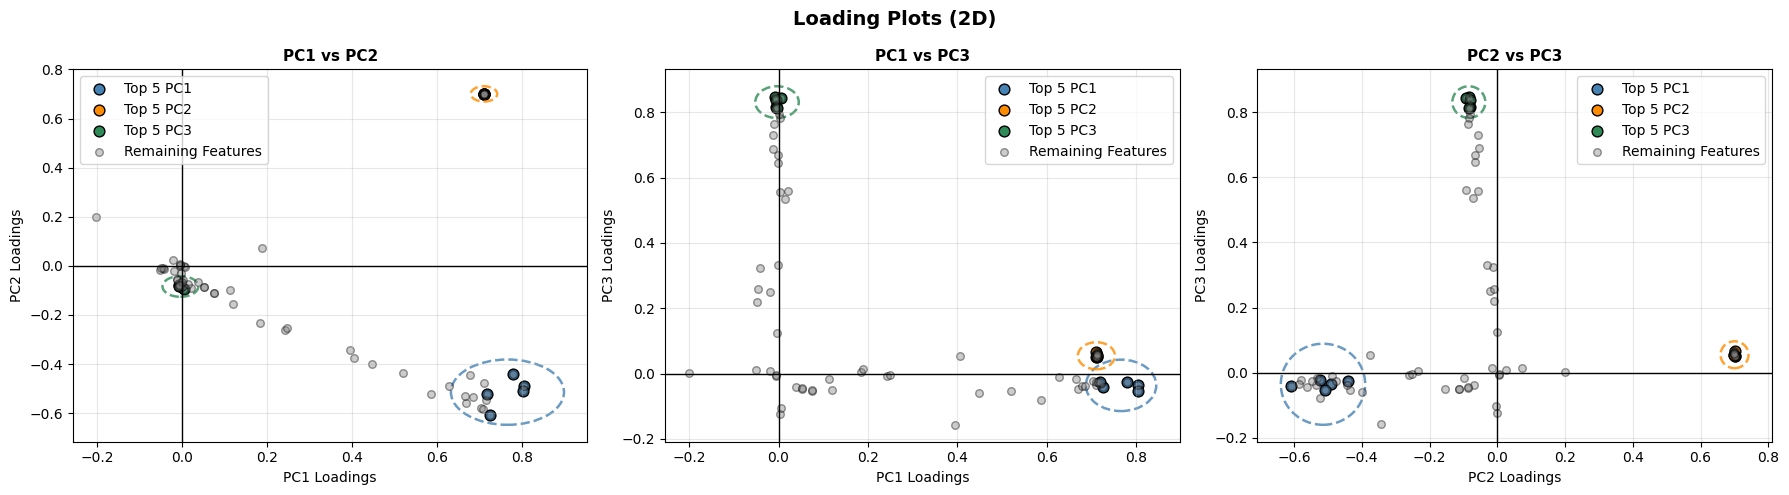

In [12]:
# Plot Loadings
pca_model.plot_loadings_2D()

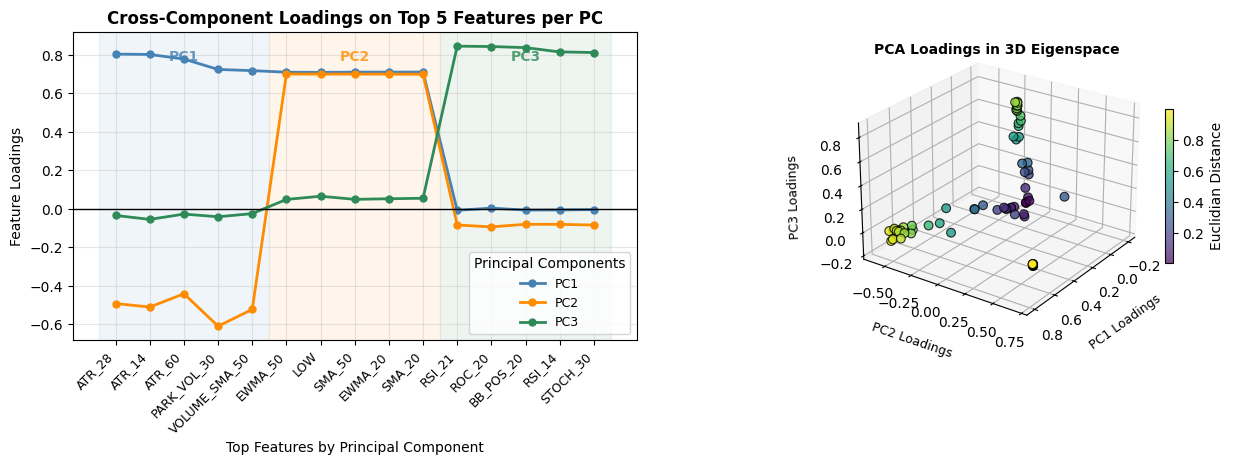

In [13]:
# Plot Loadings Summary
pca_model.plot_loadings_summary()

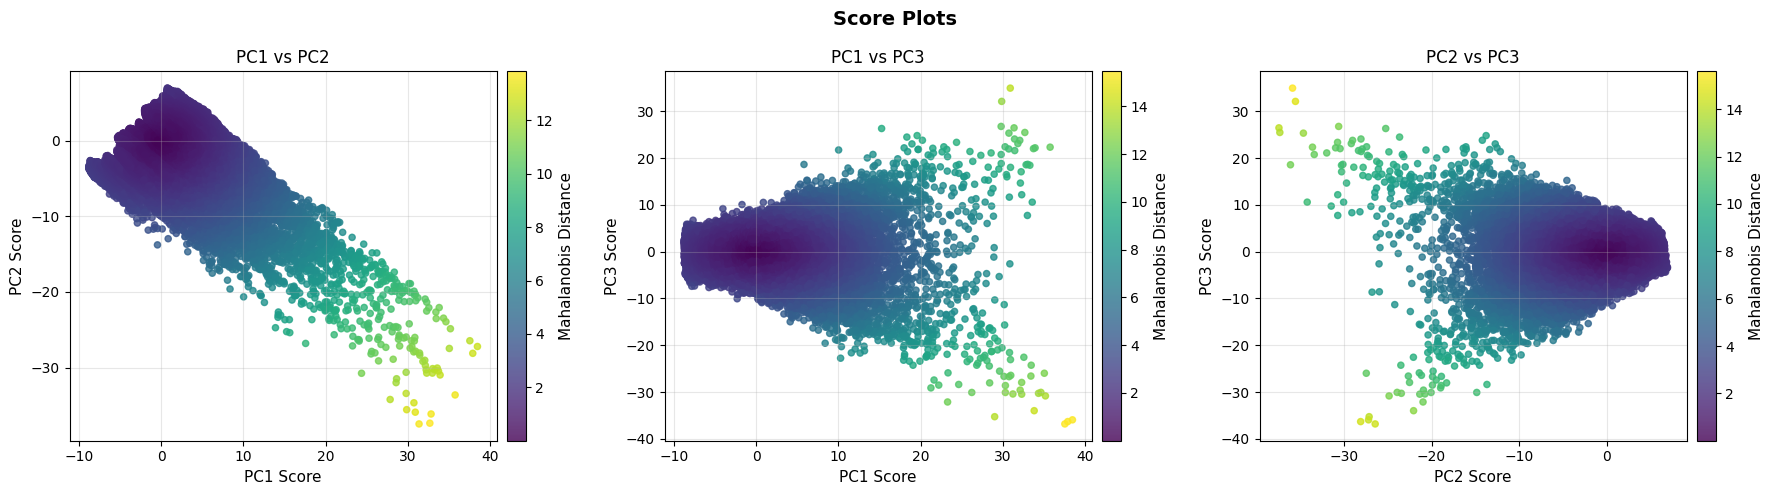

In [14]:
# Plot scores 
pca_model.plot_scores()